In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

## 데이터 로드 (zip 해제)

In [2]:
# https://drive.google.com/file/d/1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F/view?usp=sharing

import gdown, os, zipfile

file_id = '1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F'
gdown.download(f'http://drive.google.com/uc?id={file_id}', 'file.zip', quiet=False)

dir = 'hair-loss'
os.makedirs(dir, exist_ok=True)

with zipfile.ZipFile('file.zip', 'r') as z:
  z.extractall(dir)

Downloading...
From (original): http://drive.google.com/uc?id=1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F
From (redirected): https://drive.google.com/uc?id=1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F&confirm=t&uuid=b1d5b006-6372-4e76-ab4d-5e5f7d046ed2
To: /content/file.zip
100%|██████████| 1.25G/1.25G [00:12<00:00, 98.4MB/s]


In [3]:
def load_data(base_dir = 'hair-loss/Training'):
    images = []
    labels = []
    class_names = []

    for class_name in os.listdir(base_dir):
        class_name_path = os.path.join(base_dir, class_name)

        # 디렉토리인 경우만
        if os.path.isdir(class_name_path):
            for image_name in os.listdir(class_name_path):
                image_path = os.path.join(class_name_path, image_name)
                images.append(image_path)
                labels.append(int(class_name))

    return images, np.array(labels)

images, labels = load_data()

print(labels.shape)

(5402,)


## 데이터 resize

In [4]:
import tensorflow as tf
import cv2

# 리사이즈 크기 설정
IMAGE_SIZE = (224, 224)

# 결과 저장 리스트
processed_images = []

# 이미지 경로 리스트 반복 - 이미지 읽기
for image_path in images:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    processed_images.append(image)

# 최종 이미지
images = np.array(processed_images)

print(images.shape)
print(labels.shape)

(5402, 224, 224, 3)
(5402,)


## 데이터 분할
1. train + val : test = 85:15
2. train : val =  87.5 : 12.5

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

# 1. train + val : test = 90:10
tr_images, test_images, tr_labels, test_labels = train_test_split(
    images, labels, test_size=0.1, random_state=42, stratify=labels
)

# 2. train : val = 80 : 10 (train_val 데이터셋에서 다시 분할)
tr_images, val_images, tr_labels, val_labels = train_test_split(
    tr_images, tr_labels, test_size=0.111, random_state=42, stratify=tr_labels
)

tr_images, val_images = np.array(tr_images), np.array(val_images)
tr_labels, val_labels = np.array(tr_labels), np.array(val_labels)


# 결과 확인
print(f"Train data: {tr_images.shape}, {tr_labels.shape}")
print(f'Validation data: {val_images.shape}, {val_labels.shape}')
print(f'Test data: {test_images.shape}, {test_labels.shape}')

Train data: (4321, 224, 224, 3), (4321,)
Validation data: (540, 224, 224, 3), (540,)
Test data: (541, 224, 224, 3), (541,)


In [6]:
# tr_images[0] # path값이 들어옴..

## 이미지 size 확인
Width: 640, Height: 480

In [7]:
# !pip install pillow

In [8]:
# from PIL import Image
# import os

# # 이미지 파일의 경로 리스트
# tr_image_files = tr_images  # 이미지 파일 경로 리스트

# # for tr_image_path in tr_image_files:
# #     with Image.open(tr_image_path) as img:
# #         width, height = img.size
# #         print(f"Image: {os.path.basename(tr_image_path)} | Width: {width}, Height: {height}")

# img = Image.open(tr_image_files[0])
# width, height = img.size
# print(f"Image: {os.path.basename(tr_image_files[0])} | Width: {width}, Height: {height}")

## Sequence Subclass 작성
- batch 크기 별로 이미지를 로드해서 -> 모델 학습에 제공하는 class
- 리사이즈/이미지 증강/스케일링 등의 작업이 필요하다면, `__getitem()__` 안에 작성할 수 있다.
---
순서 요약
1. 리사이즈: 모델 입력 크기에 맞게 조정.
2. 증강: 회전, 잘라내기, 밝기 조정 등 데이터 변형.
3. 스케일링: 데이터를 [0, 1] 또는 [-1, 1]로 정규화.

In [9]:
# 사진 - 640 x 480
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2



class HairLossSequence(Sequence):
  def __init__(self, images, labels, batch_size=32, image_size=224, augmentor=None, preprocess_function=None, shuffle=True):
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.image_size = image_size
    self.augmentor = augmentor
    self.shuffle = shuffle
    self.preprocess_function = preprocess_function
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.images) / self.batch_size))

  def __getitem__(self, index):
    start = index * self.batch_size
    end = (index + 1) * self.batch_size
    this_batch_images = self.images[start:end]
    batch_labels = self.labels[start:end] if self.labels is not None else None

    batch_images = np.zeros((this_batch_images.shape[0], 224, 224, 3), dtype=np.float32)


    for i in range(this_batch_images.shape[0]):
      image = this_batch_images[i]

      # 스케일링
      if self.preprocess_function is not None:
        imag = self.preprocess_function(image)

      batch_images[i] = image
    return (batch_images, batch_labels) if self.labels is not None else batch_images

  def on_epoch_end(self):
    if self.shuffle:
      self.images, self.labels = shuffle(self.images, self.labels)


In [10]:
# from tensorflow.keras.utils import Sequence
# import cv2

# class HairLossSequence(Sequence):
#     def __init__(self, images_path, labels, batch_size=32, image_size=(224,224),augmentor=None, shuffle=False):
#         self.images_path = images_path
#         self.labels = labels
#         self.batch_size = batch_size
#         self.image_size = image_size
#         self.augmentor = augmentor
#         self.shuffle = shuffle


#     def __len__(self):
#         """
#         batch_size로 작업 진행 했을 때 총 횟수 (Step)
#         """
#         return int(np.ceil(self.images_path.shape[0] / self.batch_size))

#     def __getitem__(self, index):
#         """
#         index: batch_size로 나누어 작업할 때, 몇 번째 batch인지 가리키는 index
#         """
#         # 이번 배치 분할
#         start = index * self.batch_size
#         end = (index + 1) * self.batch_size # end 포함 x
#         batch_images_path = self.images_path[start:end] # 이미지 경로
#         batch_labels = self.labels[start:end]

#         batch_images = []
#         # 리사이즈 / 이미지 증강 / 스케일링
#         for image_path in batch_images_path:
#             image = cv2.imread(image_path) # 이미지 읽기
#             # 색 변환
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             # 리사이즈 (224, 224)
#             image = cv2.resize(image, self.image_size)
#             # 이미지 증강 (train set)
#             if self.augmentor is not None:
#                 self.augmentor(image = image)['image'] # dict 형태

#             # 스케일링
#             image = image / 255.0
#             batch_images.append(image)

#         return np.array(batch_images, dtype=np.float32), batch_labels # 실제 픽셀데이터(ndarray 전달)

#     def on_epoch_end(self):
#         from sklearn.utils import shuffle

#         if self.shuffle:
#             # image, label 동시에 섞기
#             self.images_path, self.labels = shuffle(self.images_path, self.labels)



## 학습/검증/평가 데이터셋 별 Sequence 객체 생성

In [11]:
# 이미지증강/shuffle 적용
import albumentations as A

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5)
])

tr_seq = HairLossSequence(tr_images, tr_labels, image_size = IMAGE_SIZE, batch_size=BATCH_SIZE, augmentor=augmentor, shuffle=True) # 증강은 훈련셋만
val_seq = HairLossSequence(val_images, val_labels, image_size = IMAGE_SIZE, batch_size=BATCH_SIZE)
test_seq = HairLossSequence(test_images, test_labels, image_size = IMAGE_SIZE, batch_size=BATCH_SIZE)

len(tr_seq), len(val_seq), len(test_seq)

# print(type(tr_seq[0]))

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


(136, 17, 17)

## ResNet 전이학습

In [12]:
# @title 사전학습된 모델 전이학습

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

def create_pretained_resnet50():
    # Bottom (특성 추출층)
    base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    # base model의 아웃풋 가져오기
    x = base_model.output

    # Top(전이층) 직접 만들기
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x) # 과적합 방지
    x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.5)(x) # 과적합 방지
    x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.3)(x) # 과적합 방지
    x = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)
    output = layers.Dense(4, activation='softmax')(x) # 최종 분류

    # 최종 모델
    model  = Model(inputs=base_model.input, outputs=output)

    return model


model = create_pretained_resnet50()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,153,668 (92.14 MB)

 Trainable params: 24,100,548 (91.94 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
# @title Class weights 적용

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 클래스 라벨과 샘플 수를 기반으로 가중치 계산
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(tr_labels),
    y=tr_labels
)

# 딕셔너리 형태로 변환
class_weight_dict = dict(enumerate(class_weights))

print(class_weight_dict)

{0: 2.523948598130841, 1: 5.746010638297872, 2: 0.3556964109318406, 3: 1.6171407185628743}


## 미세조정 2단계
특성추출층/분류층 레이어 모두 학습
과적합 방지

Epoch 1/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 132s 576ms/step - accuracy: 0.4427 - loss: 1.0192 - val_accuracy: 0.1741 - val_loss: 3.1270 - learning_rate: 1.0000e-04
Epoch 2/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 308ms/step - accuracy: 0.4224 - loss: 0.9295 - val_accuracy: 0.4389 - val_loss: 1.2294 - learning_rate: 1.0000e-04
Epoch 3/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 81s 299ms/step - accuracy: 0.5444 - loss: 0.8409 - val_accuracy: 0.3704 - val_loss: 1.4020 - learning_rate: 1.0000e-04
Epoch 4/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 292ms/step - accuracy: 0.5395 - loss: 0.8055 - val_accuracy: 0.3981 - val_loss: 1.3702 - learning_rate: 1.0000e-04
Epoch 5/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 47s 346ms/step - accuracy: 0.5480 - loss: 0.7354 - val_accuracy: 0.5296 - val_loss: 0.9400 - learning_rate: 1.0000e-04
Epoch 6/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 83s 352ms/step - accuracy: 0.6007 - loss: 0.6126 - val_accuracy: 0.6130 - val_loss: 0.8721 - learning_rate: 1.0000e-04
Epoch 7/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 74s 2

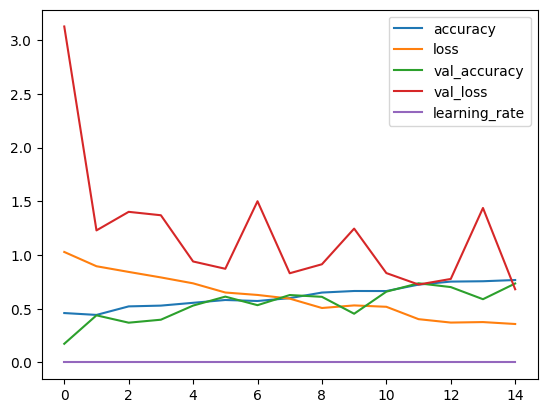

 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.5938 - loss: 0.7629

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 394ms/step - accuracy: 0.7340 - loss: 0.6899


loss: 0.6741, accuracy: 0.7468


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


# 특성추출층 unfreeze (Fine Tuning 2단계)
for layer in model.layers:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# 콜백 정의
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)


# 학습
history = model.fit(
    tr_seq,
    epochs=15,
    batch_size = 32,
    validation_data=val_seq,
    class_weight=class_weight_dict,
    callbacks=[early_stop, checkpoint, reduce_lr])


# 학습결과 시각화
pd.DataFrame(history.history).plot()
plt.show()

# 평가
loss, accuracy = model.evaluate(test_seq)
print(f'loss: {loss:.4f}, accuracy: {accuracy:.4f}')

# 모델 저장
model.save(f'ResNet50.loss-{loss:.2f}-accuracy-{accuracy:.2f}.h5')  # .h5 확장자 파일로 저장

In [16]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.460079,1.028582,0.174074,3.127041,0.0001
1,0.442722,0.895754,0.438889,1.229384,0.0001
2,0.522101,0.842854,0.370370,1.402000,0.0001
3,0.529276,0.791653,0.398148,1.370240,0.0001
4,0.555427,0.736602,0.529630,0.940049,0.0001


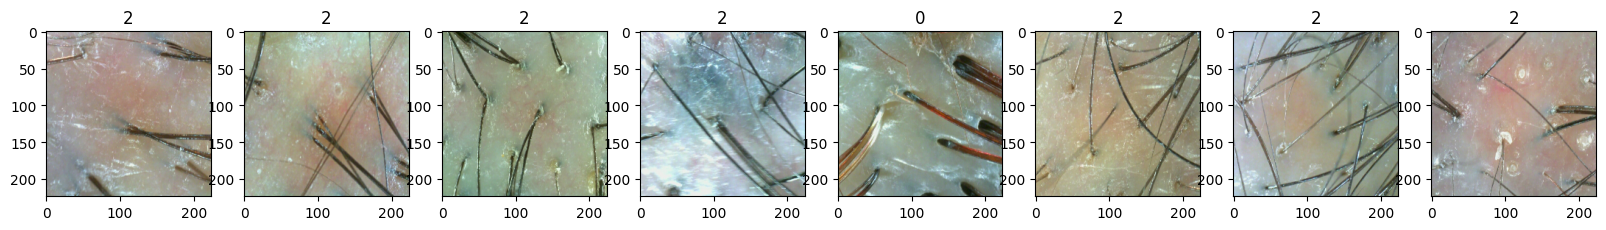

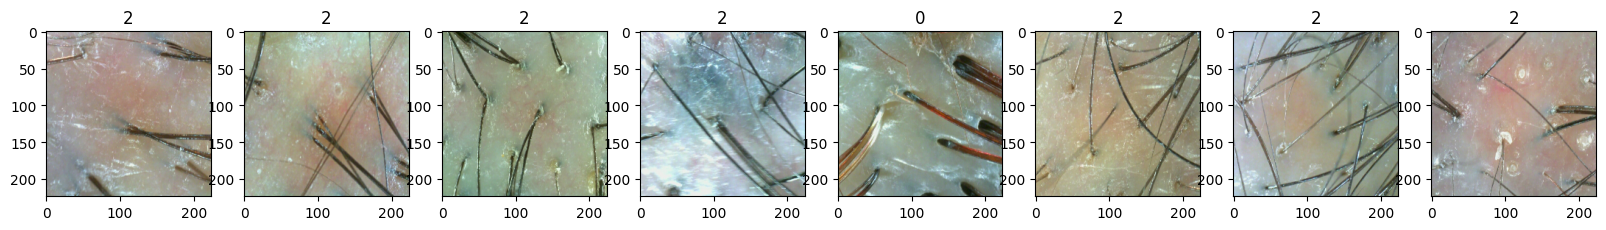

In [17]:
def show_images(images, labels, ncols=8):
    fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 6))
    for i in range(ncols):
        ax[i].imshow(images[i])
        ax[i].set_title(labels[i])
    plt.show()


show_images(test_images[:8], test_labels[:8]) # 실제
show_images(test_images[:8], test_labels[:8]) #예측